In [1]:
import math
import torch
import time
import random
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parameter import Parameter
from torch.nn import init
from torch import Tensor
from scipy.special import gamma 
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'
custom_params = {
    'font.size': 20,
    'lines.linewidth': 1,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
}

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class Fractional_Order_Matrix_Differential_Solver_FGD(torch.autograd.Function):
    @staticmethod
    def forward(ctx,input1,w,b,alpha):
        alpha = torch.tensor(alpha)
        ctx.save_for_backward(input1,w,b,alpha)
        outputs = input1@w + b
        return outputs

    @staticmethod
    def backward(ctx, grad_outputs):
        input1,w,b,alpha = ctx.saved_tensors
        x_fractional, w_fractional = Fractional_Order_Matrix_Differential_Solver_FGD.Fractional_Order_Matrix_Differential_Linear_FGD(input1,w,b,alpha)   
        x_grad = torch.mm(grad_outputs,x_fractional)
        w_grad = torch.mm(w_fractional,grad_outputs)
        b_grad = grad_outputs.sum(dim=0)
        return x_grad, w_grad, b_grad,None

    @staticmethod
    def Fractional_Order_Matrix_Differential_Linear_FGD(x,w,b,alpha):
        #w
        wf = w[:,0].view(1,-1)
        #main
        w_main = torch.mul(x,(torch.abs(wf)+1e-8)**(1-alpha)/gamma(2-alpha))
        #partial
        x_rows, x_cols = x.size()
        bias = torch.full((x_rows, x_cols),b[0].item())
        bias = bias.to(device)
        w_partial = torch.mul(torch.mm(x,wf.T).view(-1,1).expand(-1,x_cols) - torch.mul(x,wf) + bias, torch.sign(wf)*(torch.abs(wf)+1e-8)**(-alpha)/gamma(1-alpha))
        return w.T, (w_main + w_partial).T

class FLinear_FGD(nn.Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, alpha=0.9, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha

        self.weight = Parameter(torch.empty((in_features, out_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        return Fractional_Order_Matrix_Differential_Solver_FGD.apply(x, self.weight, self.bias, self.alpha)

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"

def split(X,y):
    X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.3,shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333,shuffle=False)
    return X_train,X_val,X_test,y_train,y_val,y_test

#Mean Square Error
def MSE(pred,true):
    return np.mean((pred-true)**2)

#Mean Absolute Error
def MAE(pred, true):
    return np.mean(np.abs(pred-true))


In [24]:
slide_windows_size = 192  #i.e.,input length 192
pred_length = 384     #i.e.,prediction lengths 384
stock = 'DJI'    #ETTh2
df_DJIA = pd.read_csv(r'./data/'+stock+'.csv')
# del df_DJIA['date']        #ETT2
del df_DJIA['Date']        #DJI
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()

sca_DJIA = scaler.fit_transform(df_DJIA)

features_j = 4    #ETTh2:6,DJI:4
def create_sequences(data, slide_windows_size, pred_length):
    X, y = [], []
    for i in range(len(data) - slide_windows_size - pred_length + 1):
        X.append(data[i:i+slide_windows_size, :])  # sliding window size [seq_len, features]
        y.append(data[i+slide_windows_size:i+slide_windows_size+pred_length, features_j])  
    return np.array(X), np.array(y)

X, y = create_sequences(sca_DJIA, slide_windows_size, pred_length)
X = torch.Tensor(X).to(device)
y = torch.Tensor(y).to(device)

X_train,X_val,X_test,y_train,y_val,y_test = split(X,y)   #7:2:1 

In [31]:
batch_size = 256   #16,256
set_seed()
num_feature = 5    #ETTh2:7,DJI:5 
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):   
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_size, hidden_size1)       
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = nn.Linear(hidden_size1, hidden_size2) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(hidden_size2, output_size)       

    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))  
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x

alpha = 1.0   ####1.0


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss10 = []    ###
val_loss10 = []      ###

lr =5e-3
num_epochs = 500   
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   
        optimizer.step()
    train_loss10.append(loss_sum.cpu().detach().numpy())     ###########
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss10.append(MSE_val)   ########################Validation_loss
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")  
        print('')
    

Epoch 1/500, Train Loss: 6.7379
Epoch 1/500, Val Loss: 1.0078

Epoch 2/500, Train Loss: 6.7022
Epoch 2/500, Val Loss: 1.0081

Epoch 3/500, Train Loss: 6.6499
Epoch 3/500, Val Loss: 1.0084

Epoch 4/500, Train Loss: 6.6094
Epoch 4/500, Val Loss: 1.0087

Epoch 5/500, Train Loss: 6.5561
Epoch 5/500, Val Loss: 1.0091

Epoch 6/500, Train Loss: 6.5158
Epoch 6/500, Val Loss: 1.0095

Epoch 7/500, Train Loss: 6.4860
Epoch 7/500, Val Loss: 1.0098

Epoch 8/500, Train Loss: 6.4383
Epoch 8/500, Val Loss: 1.0102

Epoch 9/500, Train Loss: 6.3994
Epoch 9/500, Val Loss: 1.0107

Epoch 10/500, Train Loss: 6.3545
Epoch 10/500, Val Loss: 1.0111

Epoch 11/500, Train Loss: 6.3166
Epoch 11/500, Val Loss: 1.0115

Epoch 12/500, Train Loss: 6.2768
Epoch 12/500, Val Loss: 1.0120

Epoch 13/500, Train Loss: 6.2372
Epoch 13/500, Val Loss: 1.0125

Epoch 14/500, Train Loss: 6.1974
Epoch 14/500, Val Loss: 1.0130

Epoch 15/500, Train Loss: 6.1290
Epoch 15/500, Val Loss: 1.0134

Epoch 16/500, Train Loss: 6.0823
Epoch 16/5

In [32]:
alpha = 0.9   ####0.1,0.3,0.5,0.7,0.9
# batch_size = 256
set_seed()
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear_FGD(input_size, hidden_size1, alpha)       
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear_FGD(hidden_size1, hidden_size2, alpha) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear_FGD(hidden_size2, output_size, alpha)       
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss09_FGD = []    ### 0.1,0.3,0.5,0.7,0.9
val_loss09_FGD = []      ### 0.1,0.3,0.5,0.7,0.9

# lr =1e-2  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss09_FGD.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss09_FGD.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

Epoch 1/500, Train Loss: 6.8588
Epoch 1/500, Val Loss: 1.0241

Epoch 2/500, Train Loss: 6.7985
Epoch 2/500, Val Loss: 1.0245

Epoch 3/500, Train Loss: 6.7292
Epoch 3/500, Val Loss: 1.0254

Epoch 4/500, Train Loss: 6.6887
Epoch 4/500, Val Loss: 1.0287

Epoch 5/500, Train Loss: 6.6222
Epoch 5/500, Val Loss: 1.0287

Epoch 6/500, Train Loss: 6.4395
Epoch 6/500, Val Loss: 1.0331

Epoch 7/500, Train Loss: 5.8818
Epoch 7/500, Val Loss: 1.0315

Epoch 8/500, Train Loss: 5.8293
Epoch 8/500, Val Loss: 0.8813

Epoch 9/500, Train Loss: 5.5313
Epoch 9/500, Val Loss: 0.8820

Epoch 10/500, Train Loss: 5.1555
Epoch 10/500, Val Loss: 0.9037

Epoch 11/500, Train Loss: 6.5002
Epoch 11/500, Val Loss: 0.7517

Epoch 12/500, Train Loss: 3.9966
Epoch 12/500, Val Loss: 0.7612

Epoch 13/500, Train Loss: 3.6297
Epoch 13/500, Val Loss: 0.7196

Epoch 14/500, Train Loss: 3.4501
Epoch 14/500, Val Loss: 0.7201

Epoch 15/500, Train Loss: 5.5427
Epoch 15/500, Val Loss: 0.9560

Epoch 16/500, Train Loss: 65.9872
Epoch 16/

In [33]:
alpha = 0.7   ####0.1,0.3,0.5,0.7,0.9
# batch_size = 256
set_seed()
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear_FGD(input_size, hidden_size1, alpha)       
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear_FGD(hidden_size1, hidden_size2, alpha) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear_FGD(hidden_size2, output_size, alpha)       
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss07_FGD = []    ### 0.1,0.3,0.5,0.7,0.9
val_loss07_FGD = []      ### 0.1,0.3,0.5,0.7,0.9

# lr =1e-2  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss07_FGD.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss07_FGD.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

Epoch 1/500, Train Loss: 6.8838
Epoch 1/500, Val Loss: 1.0247

Epoch 2/500, Train Loss: 6.8899
Epoch 2/500, Val Loss: 1.0246

Epoch 3/500, Train Loss: 6.8566
Epoch 3/500, Val Loss: 1.0241

Epoch 4/500, Train Loss: 6.8185
Epoch 4/500, Val Loss: 1.0234

Epoch 5/500, Train Loss: 6.7541
Epoch 5/500, Val Loss: 1.0247

Epoch 6/500, Train Loss: 6.7377
Epoch 6/500, Val Loss: 1.0222

Epoch 7/500, Train Loss: 6.7232
Epoch 7/500, Val Loss: 1.0205

Epoch 8/500, Train Loss: 6.6827
Epoch 8/500, Val Loss: 1.0216

Epoch 9/500, Train Loss: 6.6849
Epoch 9/500, Val Loss: 1.0229

Epoch 10/500, Train Loss: 6.6788
Epoch 10/500, Val Loss: 1.0238

Epoch 11/500, Train Loss: 6.6324
Epoch 11/500, Val Loss: 1.0268

Epoch 12/500, Train Loss: 6.5987
Epoch 12/500, Val Loss: 1.0283

Epoch 13/500, Train Loss: 6.5856
Epoch 13/500, Val Loss: 1.0300

Epoch 14/500, Train Loss: 6.5610
Epoch 14/500, Val Loss: 1.0317

Epoch 15/500, Train Loss: 6.4946
Epoch 15/500, Val Loss: 1.0346

Epoch 16/500, Train Loss: 6.4699
Epoch 16/5

In [34]:
alpha = 0.5   ####0.1,0.3,0.5,0.7,0.9
# batch_size = 256
set_seed()
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear_FGD(input_size, hidden_size1, alpha)       
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear_FGD(hidden_size1, hidden_size2, alpha) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear_FGD(hidden_size2, output_size, alpha)       
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss05_FGD = []    ### 0.1,0.3,0.5,0.7,0.9
val_loss05_FGD = []      ### 0.1,0.3,0.5,0.7,0.9

# lr =1e-2  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss05_FGD.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss05_FGD.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

Epoch 1/500, Train Loss: 6.8874
Epoch 1/500, Val Loss: 1.0240

Epoch 2/500, Train Loss: 6.8867
Epoch 2/500, Val Loss: 1.0242

Epoch 3/500, Train Loss: 6.8662
Epoch 3/500, Val Loss: 1.0242

Epoch 4/500, Train Loss: 6.8523
Epoch 4/500, Val Loss: 1.0246

Epoch 5/500, Train Loss: 6.8257
Epoch 5/500, Val Loss: 1.0247

Epoch 6/500, Train Loss: 6.8107
Epoch 6/500, Val Loss: 1.0249

Epoch 7/500, Train Loss: 6.8062
Epoch 7/500, Val Loss: 1.0258

Epoch 8/500, Train Loss: 6.7832
Epoch 8/500, Val Loss: 1.0253

Epoch 9/500, Train Loss: 6.7717
Epoch 9/500, Val Loss: 1.0257

Epoch 10/500, Train Loss: 6.7504
Epoch 10/500, Val Loss: 1.0263

Epoch 11/500, Train Loss: 6.7391
Epoch 11/500, Val Loss: 1.0259

Epoch 12/500, Train Loss: 6.7327
Epoch 12/500, Val Loss: 1.0256

Epoch 13/500, Train Loss: 6.7222
Epoch 13/500, Val Loss: 1.0260

Epoch 14/500, Train Loss: 6.7102
Epoch 14/500, Val Loss: 1.0262

Epoch 15/500, Train Loss: 6.6870
Epoch 15/500, Val Loss: 1.0276

Epoch 16/500, Train Loss: 6.6755
Epoch 16/5

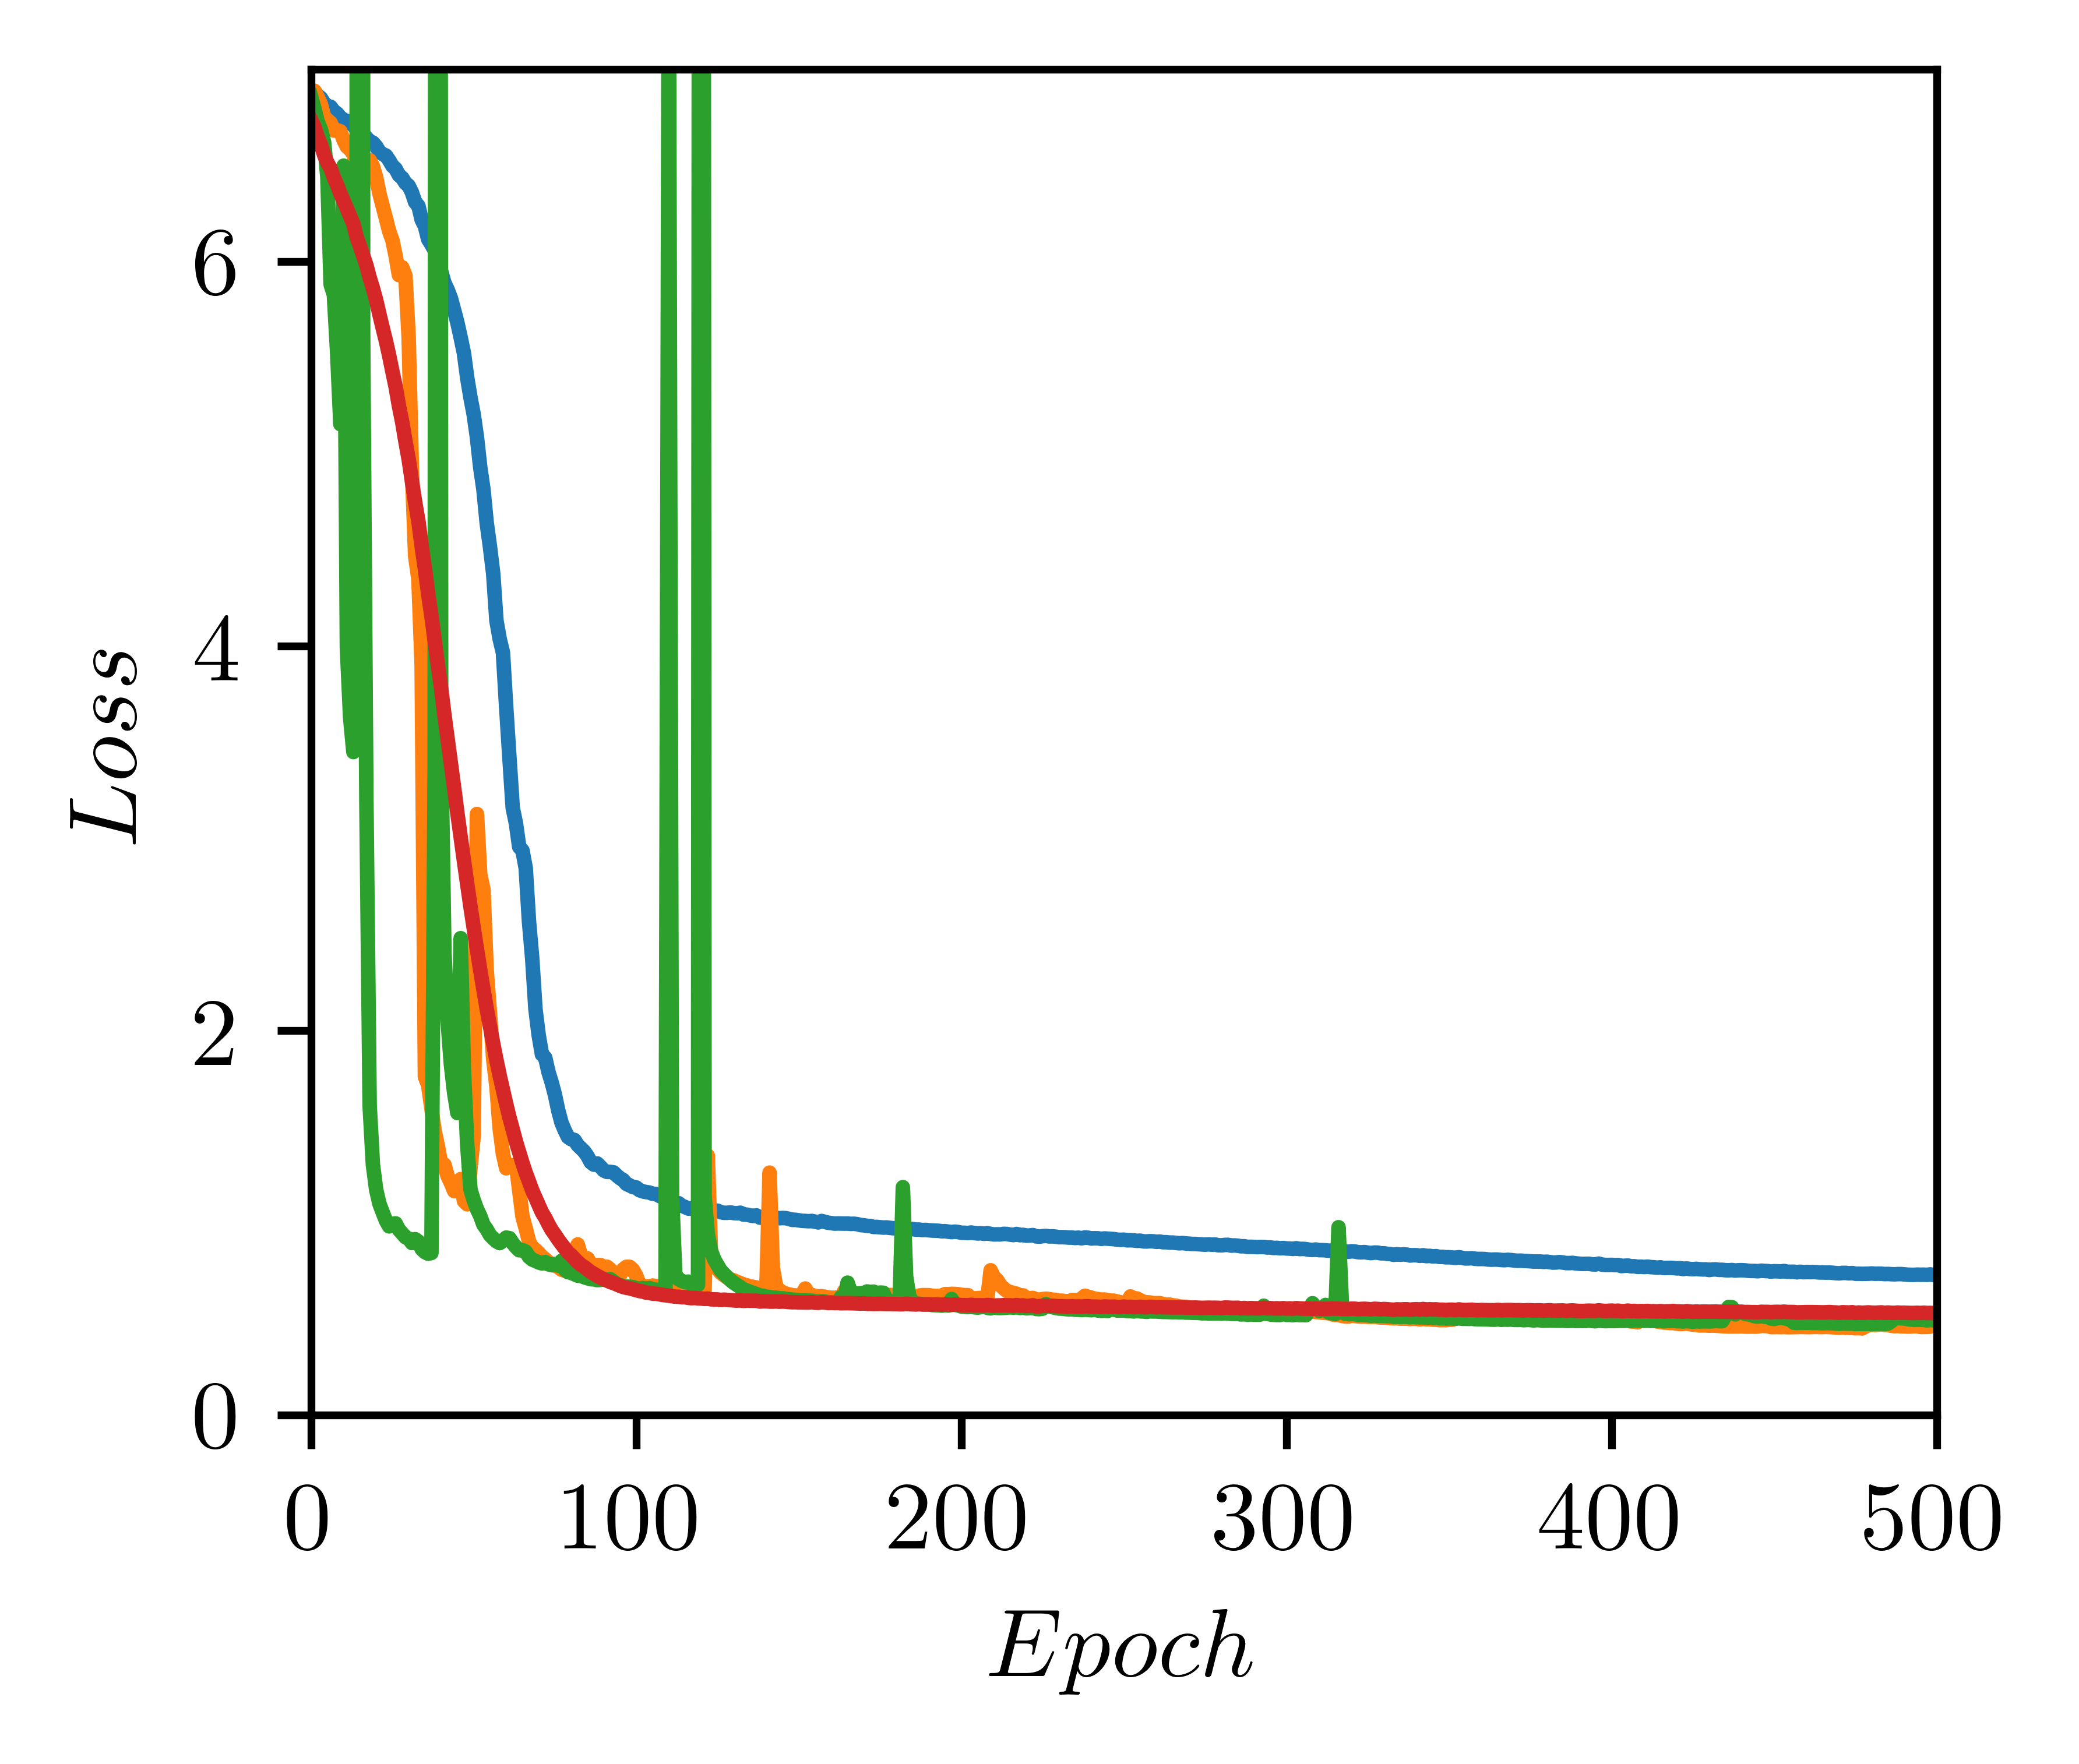

In [42]:
plt.figure(figsize=(3,2.5),dpi=1200)
plt.plot(train_loss05_FGD,label=r'$\alpha=0.5$')
plt.plot(train_loss07_FGD,label=r'$\alpha=0.7$')
plt.plot(train_loss09_FGD,label=r'$\alpha=0.9$')
plt.plot(train_loss10,label=r'$\alpha=1.0$')
plt.xlim(0,500)
plt.ylim(0,7)
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
# plt.legend()
plt.savefig('picture/fig4/Fig4g(FGD)Z-score'+'_'+str(batch_size)+'_'+str(lr)+str(stock)+'.svg',bbox_inches='tight',format='svg')
plt.savefig('picture/fig4/Fig4g(FGD)Z-score'+'_'+str(batch_size)+'_'+str(lr)+str(stock)+'.pdf',bbox_inches='tight',format='pdf')
plt.show()

In [7]:
class Fractional_Order_Matrix_Differential_Solver(torch.autograd.Function):
    @staticmethod
    def forward(ctx,input1,w,b,alpha,k,epoch):
        alpha = torch.tensor(alpha)
        k = torch.tensor(k)
        epoch = torch.tensor(epoch)
        ctx.save_for_backward(input1,w,b,alpha,k,epoch)
        outputs = input1@w + b
        return outputs

    @staticmethod
    def backward(ctx, grad_outputs):
        input1,w,b,alpha,k,epoch = ctx.saved_tensors
        x_fractional, w_fractional = Fractional_Order_Matrix_Differential_Solver.Fractional_Order_Matrix_Differential_Linear(input1,w,b,alpha,k,epoch)   
        x_grad = torch.mm(grad_outputs,x_fractional)
        w_grad = torch.mm(w_fractional,grad_outputs)
        b_grad = grad_outputs.sum(dim=0)
        return x_grad, w_grad, b_grad,None,None,None

    @staticmethod
    def Fractional_Order_Matrix_Differential_Linear(x,w,b,alpha,k,epoch):
        #w
        wf = w[:,0].view(1,-1)
        #main
        w_main = torch.mul(x,(torch.abs(wf)+1e-8)**(1-alpha)/gamma(2-alpha))
        #partial
        x_rows, x_cols = x.size()
        bias = torch.full((x_rows, x_cols),b[0].item())
        bias = bias.to(device)
        w_partial = torch.mul(torch.mm(x,wf.T).view(-1,1).expand(-1,x_cols) - torch.mul(x,wf) + bias, torch.sign(wf)*(torch.abs(wf)+1e-8)**(-alpha)/gamma(1-alpha))
        return w.T, (w_main + torch.exp(-k*epoch)*w_partial).T

class FLinear(nn.Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, alpha=0.9, k = 0.9, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.k = k

        self.weight = Parameter(torch.empty((in_features, out_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x, epoch):
        return Fractional_Order_Matrix_Differential_Solver.apply(x, self.weight, self.bias, self.alpha, self.k, epoch)

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"

In [ ]:
alpha = 0.9   ####0.1,0.3,0.5,0.7,0.9
k = 0.01
batch_size = 256
num_feature = 7 
weight_matrixs_09 = []
set_seed()
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):   
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha, k)       
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha, k) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha, k)       

    def forward(self, x, epoch=0):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x, epoch))  
        x = self.leakrelu2(self.linear2(x, epoch))
        x = self.linear3(x, epoch)
        return x

set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss09 = []    ### 0.1,0.3,0.5,0.7,0.9
val_loss09 = []      ### 0.1,0.3,0.5,0.7,0.9


lr =1e-2 
num_epochs = 500   #1500
best_loss = 10
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
for ii in range(num_epochs):
    weight_matrixs_09.append(model.linear2.weight.data.cpu().detach().numpy())
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs,ii)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss09.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9
    
    # print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss09.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

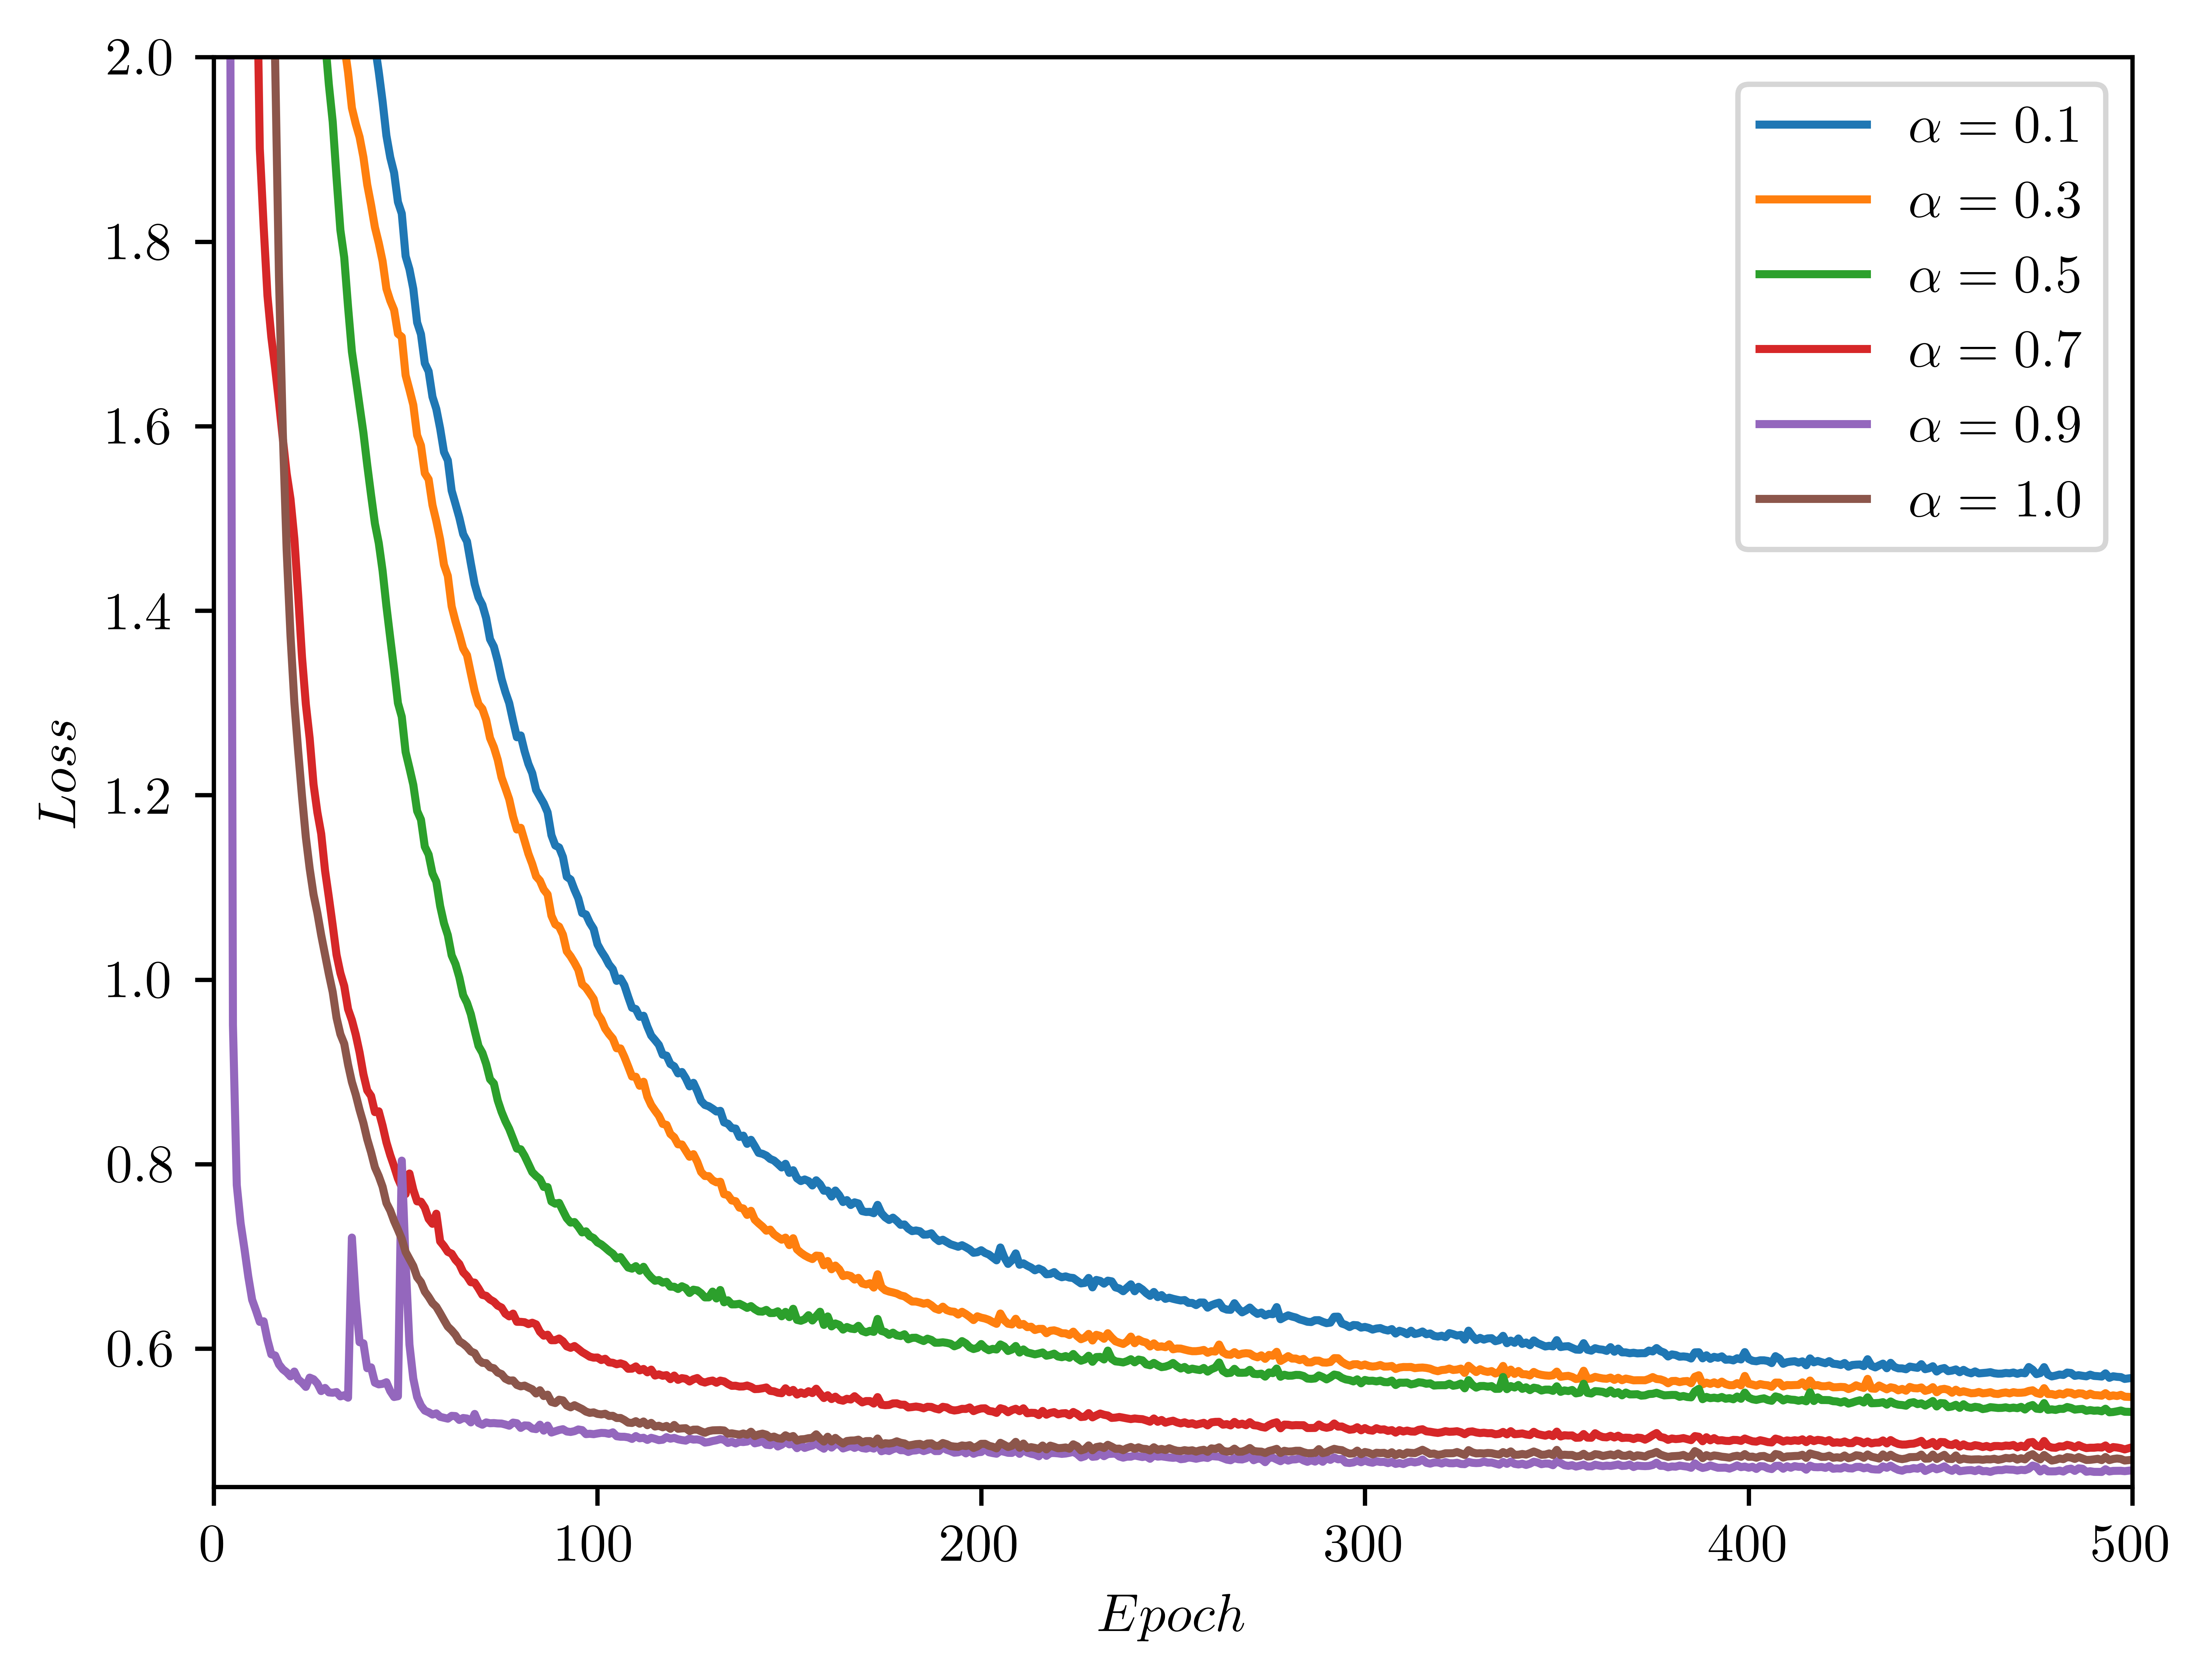

In [ ]:
plt.figure(dpi=1200)
plt.plot(train_loss01,label=r'$\alpha=0.1$')
plt.plot(train_loss03,label=r'$\alpha=0.3$')
plt.plot(train_loss05,label=r'$\alpha=0.5$')
plt.plot(train_loss07,label=r'$\alpha=0.7$')
plt.plot(train_loss09,label=r'$\alpha=0.9$')
plt.plot(train_loss10,label=r'$\alpha=1.0$')
plt.xlim(0,500)
plt.ylim(0.45,2)
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
plt.legend()
# plt.savefig('picture/fig4/Fig4(b)'+'_'+str(lr)+str(stock)+'.svg',bbox_inches='tight',format='svg')
# plt.savefig('picture/fig4/Fig4(b)'+'_'+str(lr)+str(stock)+'.pdf',bbox_inches='tight',format='pdf')
plt.show()